Binary Classifcation based on Logistic Regression

* $(x_i, y_i)$ denotes a pair of a training example and $i = 1, 2, \cdots, n$
* $$p_i = \sigma(u^Tx_i + a)$$
* $$q_i = \sigma(v^Tp_i + b)$$
* $$yh_i = \sigma(w^Tq_i + c)$$
* $$z_i = w^T x_i + b$$
* $$\sigma(z) = \frac{1}{1 + \exp(-z)}$$
* The lossfunction is defined by
$$\mathcal{L} = \frac{1}{n} \sum_{i=1}^n f_i(u, v, w, a, b, c)$$
$$f_i(u, v, w, a, b, c) = - y_i \log yh_i - (1 - y_i) \log (1 - yh_i)$$

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os

In [2]:
transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])

LABEL_IDX = 10000

# Get data

- The dataset consists of human images and horse images for the training and the validation
- The classifier should be trained using the training set
- The classifier should be tested using the validation set

In [3]:
def get_train_dataset():
    #train_data_path = 'relative path of training data set'
    train_data_path = './horse-or-human/train'
    trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
    # change the valuse of batch_size, num_workers for your program
    # if shuffle=True, the data reshuffled at every epoch 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)
    
    TRAIN_SIZE = len(trainloader)
    
    train_data = np.random.randn(LABEL_IDX + 1, TRAIN_SIZE)
    
    # load training images of the batch size for every iteration
    for i, data in enumerate(trainloader):

        # inputs is the image
        # labels is the class of the image
        inputs, labels = data
        
        train_data[:LABEL_IDX, i] = inputs.numpy().flatten()[:]
        train_data[LABEL_IDX, i] = labels[0]
    
    return TRAIN_SIZE, train_data
        
def get_validation_dataset():
    validation_data_path = './horse-or-human/validation'
    valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
    # change the valuse of batch_size, num_workers for your program
    valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1) 
    
    VALIDATION_SIZE = len(valset)
    
    validation_data = np.random.randn(LABEL_IDX + 1, VALIDATION_SIZE)
        
    # load validation images of the batch size for every iteration
    for i, data in enumerate(valloader):
        
        # inputs is the image
        # labels is the class of the image
        inputs, labels = data
                
        validation_data[:LABEL_IDX, i] = inputs.numpy().flatten()[:]
        validation_data[LABEL_IDX, i] = labels[0]
    
    return VALIDATION_SIZE, validation_data

In [4]:
# get dataset
TRAIN_SIZE, training_data = get_train_dataset()
VALIDATION_SIZE, validation_data = get_validation_dataset()

# main logic

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

def get_hx(w1, w2, w3, b1, b2, b3, data):
    p = sigmoid(np.dot(w1, data[:LABEL_IDX, :]) + b1)
    q = sigmoid(np.dot(w2, p) + b2)
    hx = sigmoid(np.dot(w3, q) + b3)
    return hx

def cross_entropy(w1, w2, w3, b1, b2, b3, data, size):
    hx = get_hx(w1, w2, w3, b1, b2, b3, data)
    d = np.nan_to_num(data[LABEL_IDX, :] * np.log(hx)) + np.nan_to_num((1 - data[LABEL_IDX, :]) * np.log(1 - hx))
    
    return -d

def loss(w1, w2, w3, b1, b2, b3, data, size):
    d = cross_entropy(w1, w2, w3, b1, b2, b3, data, size)
    
    return np.sum(d) / size

def accuracy(w1, w2, w3, b1, b2, b3, data, size):
    hx = get_hx(w1, w2, w3, b1, b2, b3, data)
    hit = 0
    
    for i in range(size):
        if hx[0][i] > 0.5:
            if data[LABEL_IDX, i] == 1:
                hit += 1
        else:
            if data[LABEL_IDX, i] == 0:
                hit += 1
                
    return hit / size

def gradient_descent():
    LEARNING_RATE = 0.05
    TOLERATION = 10e-6
    m = TRAIN_SIZE
    n1, n2 = 500, 100
    #w1 = np.zeros((n1, LABEL_IDX))
    #b1 = np.zeros((n1, 1))
    #w2 = np.zeros((n2, n1))
    #b2 = np.zeros((n2, 1))
    #w3 = np.zeros((1, n2))
    #b3 = np.zeros((1, 1))
    
    w1 = np.random.rand(n1, LABEL_IDX)
    b1 = np.random.rand(n1, 1)
    w2 = np.random.rand(n2, n1)
    b2 = np.random.rand(n2, 1)
    w3 = np.random.rand(1, n2)
    b3 = np.random.rand(1, 1)
    
    for i in range(len(w1)):
        for j in range(len(w1[0])):
            if rand() >= 0.5:
                w1[i][j] *= -1
    for i in range(len(w2)):
        for j in range(len(w2[0])):
            if rand() >= 0.5:
                w2[i][j] *= -1
    
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    
    now_loss = 0
    before_loss = 0
    
    label = training_data[LABEL_IDX, :].reshape(1, m)
    
    while True:
        z1 = np.dot(w1, training_data[:LABEL_IDX, :]) + b1
        a1 = sigmoid(z1)
        z2 = np.dot(w2, a1) + b2
        a2 = sigmoid(z2)
        z3 = np.dot(w3, a2) + b3
        a3 = sigmoid(z3)
        
        dz3 = a3 - label
        dw3 = np.dot(dz3, a2.T) / m
        db3 = np.sum(dz3, axis = 1, keepdims = True) / m
        
        w3 = w3 - LEARNING_RATE * dw3
        b3 = b3 - LEARNING_RATE * db3
        
        dz2 = np.dot(w3.T, dz3) * d_sigmoid(z2)
        dw2 = np.dot(dz2, a1.T) / m
        db2 = np.sum(dz2, axis = 1, keepdims = True) / m
        
        w2 = w2 - LEARNING_RATE * dw2
        b2 = b2 - LEARNING_RATE * db2
        
        dz1 = np.dot(w2.T, dz2) * d_sigmoid(z1)
        dw1 = np.dot(dz1, training_data[:LABEL_IDX, :].T) / m
        db1 = np.sum(dz1, axis = 1, keepdims = True) / m
        
        w1 = w1 - LEARNING_RATE * dw1
        b1 = b1 - LEARNING_RATE * db1

        now_loss = loss(w1, w2, w3, b1, b2, b3, training_data, TRAIN_SIZE)

        training_loss.append(now_loss)
        training_accuracy.append(accuracy(w1, w2, w3, b1, b2, b3, training_data, TRAIN_SIZE))
        validation_loss.append(loss(w1, w2, w3, b1, b2, b3, validation_data, VALIDATION_SIZE))
        validation_accuracy.append(accuracy(w1, w2, w3, b1, b2, b3, validation_data, VALIDATION_SIZE))

        if abs(now_loss - before_loss) < TOLERATION:
            break
        before_loss = now_loss

        #print(now_loss)

    #print(training_loss)
    #print(training_accuracy)
    #print(validation_loss)
    #print(training_accuracy[-1])
    #print(validation_accuracy)
    #print(validation_accuracy[-1])

    return training_loss, training_accuracy, validation_loss, validation_accuracy

* Apply the gradient descent algorithm
* Plot the training loss at every iteration
* Plot the testing loss at every iteration
* Plot the training accuracy at every iteration
* Plot the testing accuracy at every iteration

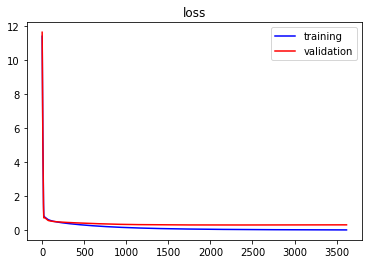

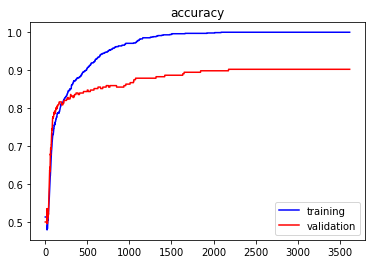

the table for the final accuracy and loss with training and validation datasets


dataset                         loss                              accuracy
training                    0.02188763518966468                    1.0
validation                  0.32016158973046693                    0.90234375


In [6]:
training_loss, training_accuracy, validation_loss, validation_accuracy = gradient_descent()
iteration = range(len(training_loss))

plt.title('loss')
plt.plot(iteration, training_loss, color = 'blue', label = 'training')
plt.plot(iteration, validation_loss, color = 'red', label = 'validation')
plt.legend()
plt.show()

plt.title('accuracy')
plt.plot(iteration, training_accuracy, color = 'blue', label = 'training')
plt.plot(iteration, validation_accuracy, color = 'red', label = 'validation')
plt.legend()
plt.show()

print('the table for the final accuracy and loss with training and validation datasets\n\n')
print('dataset' + ' ' * 25 + 'loss' + ' ' * 30 + 'accuracy')
print('training' + ' ' * 20 + str(training_loss[-1]) + ' ' * 20 + str(training_accuracy[-1]))
print('validation' + ' ' * 18 + str(validation_loss[-1]) + ' ' * 20 + str(validation_accuracy[-1]))